In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as tranforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt


In [ ]:
model = models.vgg19(pretrained = True).features
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.1MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(weights=True).features[:29]

    def forward(self,x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features


def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)

    return image.to(device)

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
image_size = 224

loader = tranforms.Compose(
    [
        tranforms.Resize((image_size,image_size)),
        tranforms.ToTensor()
    ]
)



In [ ]:
original_img = load_image('/content/drive/MyDrive/DPL302m/content-images/tubingen.png')
style_img = load_image('/content/drive/MyDrive/DPL302m/style-images/vg_starry_night_resized.jpg')

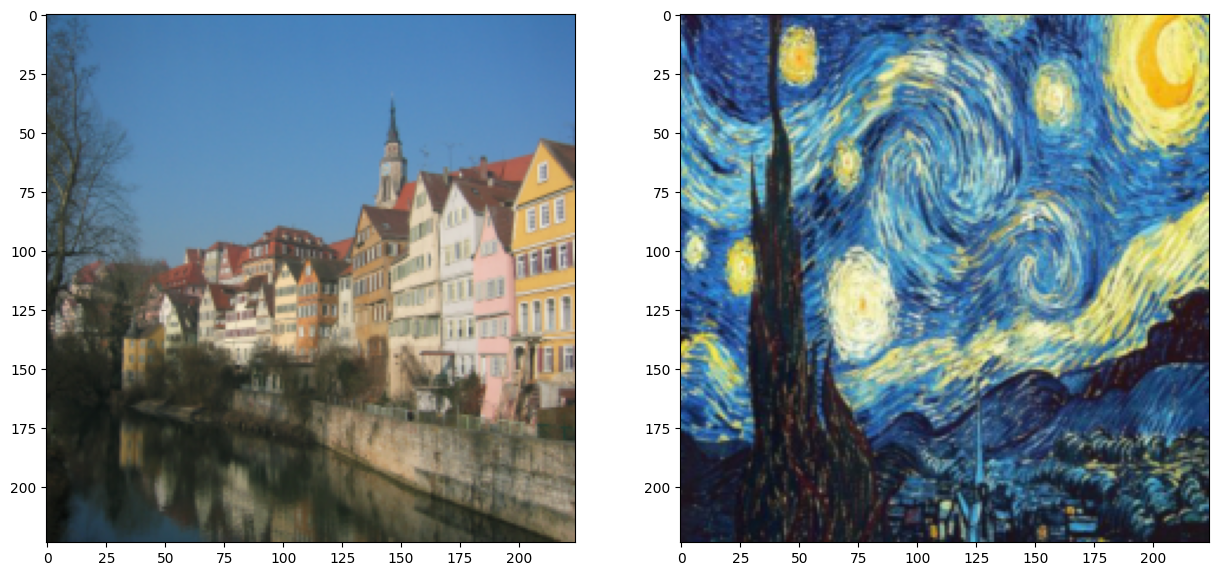

In [ ]:
# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Move tensors to CPU before converting to numpy arrays
original_img_cpu = original_img.cpu()
style_img_cpu = style_img.cpu()

# Convert tensors to numpy arrays and transpose dimensions
original_img_np = original_img_cpu.squeeze(0).numpy().transpose(1, 2, 0)
style_img_np = style_img_cpu.squeeze(0).numpy().transpose(1, 2, 0)

# Show the images
ax1.imshow(original_img_np)
ax2.imshow(style_img_np)

# Display the plot
plt.show()

In [ ]:
model = VGG().to(device).eval()
# generated = torch.randn(original_img.shape, device=device, requires_grad=True)
generated = original_img.clone().requires_grad_(True)

#Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
  generated_features = model(generated)
  original_img_features = model(original_img)
  style_features = model(style_img)

  style_loss = original_loss = 0

  for gen_feature, orig_feature, style_feature in zip(
      generated_features, original_img_features, style_features
  ):
      batch_zize, channel, height, width = gen_feature.shape
      original_loss += torch.mean((gen_feature - orig_feature) ** 2)

      # Compute Gram Matrix
      G = gen_feature.view(channel, height*width).mm(
          gen_feature.view(channel, height*width).t()
      )

      A = style_feature.view(channel, height*width).mm(
          style_feature.view(channel, height*width).t()
      )

      style_loss += torch.mean((G - A) ** 2)

  total_loss = alpha*original_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if step % 200 == 0:
    print(total_loss)
    save_image(generated, 'generated.png')
    # show_image(generated)



tensor(117946.1797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3928.4424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2050.6680, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1460.5833, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1163.0355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(975.1730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(845.3618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(751.6895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(679.4951, device='cuda:0', grad_fn=<AddBackward0>)
tensor(621.9633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(575.3702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(536.8500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(504.1046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(475.4137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(451.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(429.9121, device='cuda:0', grad_fn=<AddBackward0>)
tensor(411.3953, device='cuda:0', grad_fn=<AddBackward0>)
tensor(

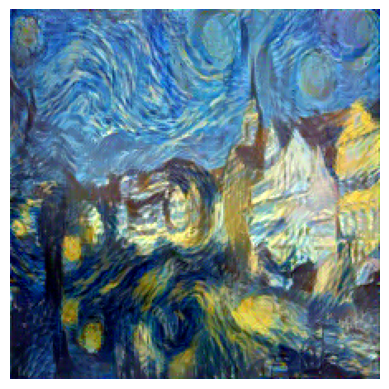

In [ ]:
# Move the generated image to the CPU and convert it to a numpy array
generated_img_cpu = generated.cpu().detach()
generated_img_np = generated_img_cpu.squeeze(0).numpy().transpose(1, 2, 0)

# Display the generated image
plt.imshow(generated_img_np)
plt.axis('off')
plt.show()